# Getting Started with Pioneer

This notebook is intended to get you familiar with the Pioneer Analysis environment with best practices for querying and saving datasets. The notebook environment is secured, so only **you** will have access to this particular notebook. You can, however, export the notebook. We will cover the basics of the `bq` command-line tool, working with BigQuery within the notebook environment, and how to share your work with other people on your team.

Note that Notebook instances do *not* have access to the wider internet.

In [1]:
! timeout 10 ping mozilla.org

PING mozilla.org (63.245.208.195) 56(84) bytes of data.


## `bq` basics and schemas

You will not have access to the standard BigQuery console for querying data. To navigate the BigQuery project, the `bq` command-line tool will be your primary interface. In Jupyter, the bang prefix (i.e. `!`) will run a command in the default shell. Run `bq` or `bq --help` to get a list of available commands or reference [Using the bq command-line tool](https://cloud.google.com/bigquery/docs/bq-command-line-tool) for more details.

Show details about the current project.

In [2]:
! bq show

Project moz-fx-data-pion-nonprod-b3c9

  friendlyName   
 --------------- 
  pioneer-debug  



List the available datasets in this project. The study dataset corresponds to the namespace defined in [`mozilla/mozilla-pipeline-schemas`](https://github.com/mozilla-services/mozilla-pipeline-schemas/tree/generated-schemas/schemas). This contains read-only views of pings that have been ingested during the study. The `analysis` dataset is for storing and sharing tables derived from study pings.

In [3]:
! bq ls

    datasetId    
 --------------- 
  analysis       
  pioneer_debug  


In [4]:
! bq ls pioneer_debug

     tableId      Type                   Labels                   Time Partitioning   Clustered Fields  
 --------------- ------ ---------------------------------------- ------------------- ------------------ 
  debug_v1        VIEW   source_dataset_id:pioneer_debug_stable                                         
                         schemas_build_id:202006140144_d5ead7a                                          
  debug_v1_live   VIEW   source_dataset_id:pioneer_debug_live                                           
                         schemas_build_id:202006140144_d5ead7a                                          
  errors          VIEW                                                                                  


The study table contains partitions with full days of deduplicated data. These are mapped directly from `mozilla/mozilla-pipeline-schemas`, taking on the form `{document_type}_v{document_version}`. The `{table_id}_live` table contains up-to-date pings ingested from the last 5-10 minutes with limited retention. Finally, the errors table contains pings that have been rejected due to invalid schemas.

To view the schema for a table, use the `bq show` command.

In [5]:
! bq show pioneer_debug.debug_v1

Table moz-fx-data-pion-nonprod-b3c9:pioneer_debug.debug_v1

   Last modified                   Schema                   Type   Expiration                   Labels                  
 ----------------- --------------------------------------- ------ ------------ ---------------------------------------- 
  16 Jun 19:21:41   |- additional_properties: string        VIEW                source_dataset_id:pioneer_debug_stable  
                    |- datetime: timestamp                                      schemas_build_id:202006140144_d5ead7a   
                    |- document_id: string                                                                              
                    +- metadata: record                                                                                 
                    |  +- geo: record                                                                                   
                    |  |  |- city: string                                                    

## Querying Study Tables and Destination Tables
The BigQuery tables available in the study dataset are views on [Mozilla's Data Platform standard BigQuery table layout](https://docs.telemetry.mozilla.org/cookbooks/bigquery/querying.html#table-layout-and-naming). These will be the primary source for many analyses.

The study tables are _historical ping tables_ that are populated once a day. They never contain partial days of data and are deduplicated by `document_id`. These are partitioned by `submission_timestamp` and require the use of a partition filter (i.e. `WHERE` clause on `submission_timestamp`) to query. The _live ping tables_ have the same structure, but slightly different semantics in terms of availability.

To query in the notebook, use [the `%%bigquery` magic](https://googleapis.dev/python/bigquery/latest/magics.html). 

In [6]:
%%bigquery
SELECT 
    submission_timestamp, 
    study_name, 
    document_id
FROM
    pioneer_debug.debug_v1
WHERE
    date(submission_timestamp) > date_sub(current_date, interval 30 day)
LIMIT 5

,submission_timestamp,study_name,document_id
0,2020-06-01 07:33:25.110699+00:00,pioneer-v2-example,f4b4ff12-357f-1348-a5da-77f150207a71
1,2020-06-01 20:01:31.908587+00:00,pioneer-v2-example,937814bc-6efd-4ae9-974a-95fc386f8766
2,2020-06-01 20:04:32.444225+00:00,pioneer-v2-example,517b53cc-e11e-cf41-8bde-c4fa8d2dbde5
3,2020-06-01 15:40:01.567397+00:00,pioneer-v2-example,2299ce62-1a9a-e443-b62e-f18f066f1740
4,2020-06-01 20:01:31.916964+00:00,pioneer-v2-example,08cfb78b-a704-44ea-afa1-dc861ee6e916


Queries can be stored directly into a destination table in the analysis dataset.

In [7]:
%%bigquery --destination_table analysis.my_table
SELECT 
    submission_timestamp, 
    study_name, 
    document_id
FROM
    pioneer_debug.debug_v1
WHERE
    date(submission_timestamp) > date_sub(current_date, interval 30 day)

,submission_timestamp,study_name,document_id
0,2020-06-01 20:01:31.922322+00:00,pioneer-v2-example,55c93f79-e0a6-432a-bf25-5b9d08df214b
1,2020-06-16 11:19:50.158683+00:00,pioneer-v2-example,58133145-e671-446c-a55f-c6c5b4d51e7a
2,2020-06-01 20:01:31.918860+00:00,pioneer-v2-example,e45f8954-5387-4bdb-86ad-da4c28408bd5
3,2020-06-05 19:35:18.110024+00:00,pioneer-v2-example,bec24acf-f9b4-7e42-a529-a5ff568fb59c
4,2020-05-27 23:20:18.424399+00:00,pioneer-v2-example,d8a7fee8-db56-844b-a93e-eb886b1f169a
...,...,...,...
80,2020-06-01 19:33:09.087377+00:00,pioneer-v2-example,06812c34-1061-e04b-867b-58b872be800d
81,2020-05-27 23:20:18.102596+00:00,pioneer-v2-example,6d32301b-6ce6-e343-87e1-b86cb981ac20
82,2020-05-30 21:26:23.489637+00:00,pioneer-v2-example,5e67c507-9696-5449-9899-36f3c885ee6f
83,2020-05-28 06:12:29.741101+00:00,pioneer-v2-example,27de08c9-2d50-ea4f-bfe0-fefec533dd52


We can see the table in our analysis dataset.

In [8]:
! bq ls analysis

  tableId    Type    Labels   Time Partitioning   Clustered Fields  
 ---------- ------- -------- ------------------- ------------------ 
  my_table   TABLE                                                  


In [9]:
! bq show analysis.my_table

Table moz-fx-data-pion-nonprod-b3c9:analysis.my_table

   Last modified                  Schema                 Total Rows   Total Bytes   Expiration   Time Partitioning   Clustered Fields   Labels  
 ----------------- ------------------------------------ ------------ ------------- ------------ ------------------- ------------------ -------- 
  24 Jun 21:05:23   |- submission_timestamp: timestamp   85           5610                                                                      
                    |- study_name: string                                                                                                       
                    |- document_id: string                                                                                                      



The resulting table is available from any other notebook environment within the project. This is the primary mechanism for sharing intermediate results.

In [10]:
%%bigquery
SELECT * FROM analysis.my_table LIMIT 5

,submission_timestamp,study_name,document_id
0,2020-06-01 20:01:31.922322+00:00,pioneer-v2-example,55c93f79-e0a6-432a-bf25-5b9d08df214b
1,2020-06-16 11:19:50.158683+00:00,pioneer-v2-example,58133145-e671-446c-a55f-c6c5b4d51e7a
2,2020-06-01 20:01:31.918860+00:00,pioneer-v2-example,e45f8954-5387-4bdb-86ad-da4c28408bd5
3,2020-06-05 19:35:18.110024+00:00,pioneer-v2-example,bec24acf-f9b4-7e42-a529-a5ff568fb59c
4,2020-05-27 23:20:18.424399+00:00,pioneer-v2-example,d8a7fee8-db56-844b-a93e-eb886b1f169a


## Working with Pandas DataFrames

Queries from BigQuery can be serialized into a Pandas dataframe for further analysis, and written back into BigQuery. Lets generate a plot of distinct documents per day.

In [11]:
import matplotlib.pyplot as plt

In [12]:
%%bigquery my_pandas_df
SELECT
    *
FROM
    analysis.my_table

In [13]:
my_pandas_df.head()

,submission_timestamp,study_name,document_id
0,2020-06-01 20:01:31.922322+00:00,pioneer-v2-example,55c93f79-e0a6-432a-bf25-5b9d08df214b
1,2020-06-16 11:19:50.158683+00:00,pioneer-v2-example,58133145-e671-446c-a55f-c6c5b4d51e7a
2,2020-06-01 20:01:31.918860+00:00,pioneer-v2-example,e45f8954-5387-4bdb-86ad-da4c28408bd5
3,2020-06-05 19:35:18.110024+00:00,pioneer-v2-example,bec24acf-f9b4-7e42-a529-a5ff568fb59c
4,2020-05-27 23:20:18.424399+00:00,pioneer-v2-example,d8a7fee8-db56-844b-a93e-eb886b1f169a


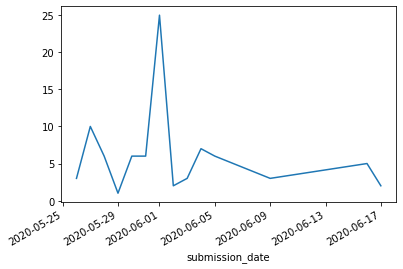

In [14]:
my_pandas_df["submission_date"] = my_pandas_df.submission_timestamp.dt.floor("d")
my_pandas_df.groupby("submission_date").document_id.nunique().plot()
plt.show()

We can accomplish the same task by pushing most of the work onto BigQuery. This is preferable because it reads less rows into memory and requires less work from the notebook instance.

In [15]:
%%bigquery my_aggregated_df
SELECT
    TIMESTAMP_TRUNC(submission_timestamp, day) as submission_date,
    COUNT(DISTINCT document_id) as n_documents
FROM
    analysis.my_table
GROUP BY
    submission_date
ORDER BY
    submission_date

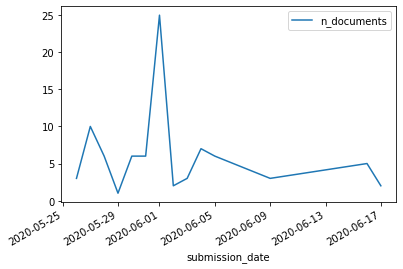

In [16]:
my_aggregated_df.plot("submission_date", "n_documents")
plt.show()

We can now save the results of our Pandas dataframe into our analysis environment. 

If the `pandas_gbq` package is installed, like in the Kaggle image, then Pandas can write directly into a table. See [the Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_gbq.html) for reference.

```python
my_aggregated_df.to_gbq("analysis.my_aggregated_table")
```

Instead, we'll use the [Google Cloud SDK to write into a table](https://cloud.google.com/bigquery/docs/datalab-migration#google-cloud-bigquery_7). Refer to the [`google-cloud-bigquery` api docs](https://googleapis.dev/python/bigquery/latest/index.html) for more details.

In [17]:
from google.cloud import bigquery

client = bigquery.Client()
job = client.load_table_from_dataframe(my_aggregated_df, "analysis.my_aggregated_table")
job.result()

In [18]:
! bq ls analysis

        tableId         Type    Labels   Time Partitioning   Clustered Fields  
 --------------------- ------- -------- ------------------- ------------------ 
  my_aggregated_table   TABLE                                                  
  my_table              TABLE                                                  


In [19]:
%%bigquery
SELECT * FROM analysis.my_aggregated_table

,submission_date,n_documents
0,2020-05-29 00:00:00+00:00,1
1,2020-06-02 00:00:00+00:00,2
2,2020-06-17 00:00:00+00:00,2
3,2020-05-26 00:00:00+00:00,3
4,2020-06-03 00:00:00+00:00,3
5,2020-06-09 00:00:00+00:00,3
6,2020-06-16 00:00:00+00:00,5
7,2020-05-28 00:00:00+00:00,6
8,2020-05-30 00:00:00+00:00,6
9,2020-05-31 00:00:00+00:00,6


## Appendix

In [20]:
# cleanup
! bq rm -f analysis.my_table
! bq rm -f analysis.my_aggregated_table